### Importing the modules we use

In [1]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter


from sklearn.linear_model import LinearRegression


import numpy as np
from random import random, seed
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.utils import resample
from sklearn.model_selection import KFold, cross_val_score
plt.rcParams['font.size'] = 14


## Functions used in the task

In [2]:


# FrankeFunction, from lecture notes
def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)

    return term1 + term2 + term3 + term4 


# Defining the R2 function, from lecture notes
def R2(y_data, y_model):
    return 1 - np.sum((y_data - y_model) ** 2) / np.sum((y_data - np.mean(y_data)) ** 2)


# Defining the Mean square error, from lecture notes
def MSE(y,ytilde):
    n = len(y)
    return 1/n * np.sum(np.abs(y-ytilde)**2)



# Creating the design matrix, from lecture notes
def create_X(x, y, n ):
    if len(x.shape) > 1:
        x = np.ravel(x)
        y = np.ravel(y)

    N = len(x)
    l = int((n+1)*(n+2)/2) # Number of elements in beta
    X = np.ones((N,l))

    for i in range(1,n+1):
        q = int((i)*(i+1)/2)
        for k in range(i+1):
            X[:,q+k] = (x**(i-k))*(y**k)

    return X


# making the OCS regression
def OLSmethod(X,z):
    # Takes in the design matrix and the data we wish to fit
    # Returns the beta coefficients
    return np.linalg.pinv(X.T @ X) @ X.T @ z



#Ridgeregression
def ridgeregg(X,y, lmb = 0.0001):
    # Takes in the design matrix, datapoints and the hyperparameter lambda
    # Returns the ridge coefficients
    XtX = X.T @ X
    p =np.shape(XtX)[0]
    return np.linalg.pinv(XtX +  lmb * np.identity(p)) @ X.T @ y

#Lassoregression using sklern
def lassoregg(X,y,lmb = 0.0001):
    # Takes in the design matrix, datapoints and the hyperparameter lambda
    # Returns the lasso coefficients
    RegLasso = Lasso(lmb,fit_intercept=False,max_iter=10000)
    RegLasso.fit(X,y)
    return RegLasso.coef_
    #pred_y = RegLasso.predict(X)
    
    

# Plotting the 3D surface of the FrankFunction
def surfaceplot(x,y,z):

    fig = plt.figure()
    ax = fig.gca(projection='3d')

    # Plot the surface.
    surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)

    # Customize the z axis.
    ax.set_zlim(-0.10, 1.40)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)

    plt.show()

    
# A function that prints the MSE and R2 in a neat way
def printQ(xdata,xmodel):
    print("--------------------------------------------------------")
    print(f"MSE = |{MSE(xdata,xmodel)}|, R2 = |{r2_score(xdata,xmodel)}|")
    print("--------------------------------------------------------\n")
    
# calculating the MSE, bias and variance for OLS using the bootstrap method
def BootstrapOLS(X_train,X_test,z_train,z_test,numberOfStraps):
    MSEdeglisttest = np.zeros(numberOfStraps)
    MSEdeglisttrain = np.zeros(numberOfStraps)
    bias = np.zeros(numberOfStraps)
    variance = np.zeros(numberOfStraps)
    for i in range(numberOfStraps):
        bootX,bootz = resample(X_train,z_train.reshape(-1,1))
        bootbetaOLS = OLSmethod(bootX,bootz)
        # Making out model and adding it to a list
        ztilde = X_test @ bootbetaOLS
        zpred = X_train @ bootbetaOLS
        MSEdeglisttest[i] =MSE(z_test,ztilde)
        MSEdeglisttrain[i]= MSE(z_train,zpred)
        bias[i],variance[i] = biassVariance(z_test,ztilde)
    return np.mean(MSEdeglisttest), np.mean(MSEdeglisttrain), np.mean(bias), np.mean(variance)

# calculating the MSE, bias and variance for Ridge regression using the bootstrap method
def BootstrapRidge(X_train,X_test,z_train,z_test,lam,numberOfStraps):
    MSEdeglisttest = np.zeros(numberOfStraps)
    MSEdeglisttrain = np.zeros(numberOfStraps)
    bias = np.zeros(numberOfStraps)
    variance = np.zeros(numberOfStraps)
    for i in range(numberOfStraps):
        bootX,bootz = resample(X_train,z_train.reshape(-1,1))
        bootbetaRidge = ridgeregg(bootX,bootz,lam)
        # Making out model and adding it to a list
        ztilde = X_test @ bootbetaRidge
        zpred = X_train @ bootbetaRidge
        MSEdeglisttest[i] =MSE(z_test,ztilde)
        MSEdeglisttrain[i]= MSE(z_train,zpred)
        bias[i],variance[i] = biassVariance(z_test,ztilde)
             
    return np.mean(MSEdeglisttest), np.mean(MSEdeglisttrain), np.mean(bias), np.mean(variance)



# calculating the MSE, bias and variance for lassoregression using the bootstrap method
def BootstrapLasso(X_train,X_test,z_train,z_test,lam,numberOfStraps):
    MSEdeglisttest = np.zeros(numberOfStraps)
    MSEdeglisttrain = np.zeros(numberOfStraps)
    bias = np.zeros(numberOfStraps)
    variance = np.zeros(numberOfStraps)
    for i in range(numberOfStraps):
        bootX,bootz = resample(X_train,z_train.reshape(-1,1))
        RegLasso = Lasso(lam,fit_intercept = False,max_iter=10000)
        RegLasso.fit(bootX,bootz)
        #Creating model and adding to list
        ztilde = RegLasso.predict(X_train)
        zpred = RegLasso.predict(X_test)
        # Saving the MSE of the test and train sets
        MSEdeglisttest[i] =MSE(z_test,zpred)
        MSEdeglisttrain[i]= MSE(z_train,ztilde)
        bias[i],variance[i] = biassVariance(z_test,ztilde)
    return np.mean(MSEdeglisttest), np.mean(MSEdeglisttrain), np.mean(bias), np.mean(variance)


# A function for plotting the MSE for the OLS method with bootstrap for a given n complexity
def plotMSEcomplexity(x,y,z,n):
    MSElisttest = []
    MSElisttrain = []
    biasList =[]
    varianceList =[] 
    n = n+1
    complexity = np.arange(n)
    print(f"The polynomial range is [{complexity[0]},{complexity[-1]}] ")
    
    # Running over the degrees of polynomails
    for degree in complexity:
        # Creating the designmatrix and splitting into train and test
        X = create_X(x,y,degree)
        X_train, X_test, z_train, z_test = train_test_split(X, z.reshape(-1,1), test_size=0.2)
        
        numberOfStraps = 100
        MSE_train, MSE_test,bias,variance = BootstrapOLS(X_train,X_test,z_train,z_test,numberOfStraps)
        
        
        # Appending the mean to the MSE list when the loop has run for its specific degree
        MSElisttest.append(MSE_train)
        MSElisttrain.append(MSE_test)
        biasList.append(bias)
        varianceList.append(variance)
        
        
    plt.plot(complexity,MSElisttest,"r", label = "test")
    plt.plot(complexity,MSElisttrain,"k", label = "train")
    plt.xlabel("Polynomial degree")
    plt.grid()
    plt.ylabel("MSE")
    plt.tight_layout()
    #plt.title("Figure of the MSE as a function of the complexity of the model")
    plt.legend()
    plt.savefig("hastie211.pdf")
    plt.show()
    
    
    
    plt.plot(complexity,biasList,"r", label = "bias",ls='',marker='o')
    plt.plot(complexity,varianceList,"k", label = "variance",ls='',marker='o')
    plt.xlabel("Polynomial degree")
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.savefig("biasvariancetask2.pdf")
    plt.show()
    
    
#finding the confidence intervall for beta
def confidense(y,X): 
    var = 1 
    XtX = np.linalg.pinv(X.T@X)
    conf = 2*var*np.sqrt(np.diag(XtX))
    return conf


# Finding the bias and the variance
def biassVariance(y,y_pred): 
    mean_pred = np.mean(y_pred)
    bias = np.mean((y - mean_pred)**2)
    variance = np.mean((y_pred - mean_pred)**2)
    return bias, variance

# A function that returns the MSE for a k fold analysis of the OLS method
def k_foldOLS(Data, k,X): 
    "Splitting the data"
    k_split = KFold(n_splits = k)
    "CV to calculate MSE"
    k_scores= np.zeros(k)
    i = 0
    for k_train_index, k_test_index in k_split.split(X):
        #print(Data.shape)
        k_xtrain = X[k_train_index]
        k_ytrain = Data[k_train_index]
        
       # print(k_xtrain)
        
        k_xtest = X[k_test_index]
        k_ytest = Data[k_test_index]

        #k_Xtrain = poly.fit_transform(k_xtrain[:, np.newaxis])
        "Finding betaOLS for each k"
        beta_k_OLS = OLSmethod(k_xtrain, k_ytrain)

        #k_Xtest = poly.fit_transform(k_xtest[:, np.newaxis])
        model_predict = k_xtest @ beta_k_OLS

        k_scores[i] = MSE(k_ytest, model_predict)

        i += 1
  #  print(k_scores)
    MSE_kfold = np.mean(k_scores)
   # print('MSE for k-fold OLS')
   # print(MSE_kfold)
    return MSE_kfold


# A function that returns the MSE for a k fold analysis of the Ridge method
def k_foldRigd(Data, k,X,lam=0.001): 
    "Splitting the data"
    k_split = KFold(n_splits = k)
    "CV to calculate MSE"
    k_scores= np.zeros(k)
    i = 0
    for k_train_index, k_test_index in k_split.split(X):
        #print(k_train_index)
        k_xtrain = X[k_train_index]
        k_ytrain = Data[k_train_index]
        
       # print(k_xtrain)
        
        k_xtest = X[k_test_index]
        k_ytest = Data[k_test_index]

        #k_Xtrain = poly.fit_transform(k_xtrain[:, np.newaxis])
        "Finding betaOLS for each k"
        beta_k_Ridge = ridgeregg(k_xtrain, k_ytrain,lam)

        #k_Xtest = poly.fit_transform(k_xtest[:, np.newaxis])
        model_predict = k_xtest @ beta_k_Ridge

        k_scores[i] = MSE(k_ytest, model_predict)

        i += 1
  #  print(k_scores)
    MSE_kfold = np.mean(k_scores)
   # print('MSE for k-fold OLS')
   # print(MSE_kfold)
    return MSE_kfold


# A function that returns the MSE for a k fold analysis of the Lasso method
def k_foldLasso(Data, k,X,lam=0.001):
   # "Splitting the data"
    k_split = KFold(n_splits = k)
   # "CV to calculate MSE"
    k_scores= np.zeros(k)
    i = 0
    for k_train_index, k_test_index in k_split.split(X):
        #print(k_train_index)
        k_xtrain = X[k_train_index]
        k_ytrain = Data[k_train_index]
        
       # print(k_xtrain)
        
        k_xtest = X[k_test_index]
        k_ytest = Data[k_test_index]

        #k_Xtrain = poly.fit_transform(k_xtrain[:, np.newaxis])
        "Finding betaOLS for each k"
        beta_k_Lasso = lassoregg(k_xtrain, k_ytrain,lam)

        #k_Xtest = poly.fit_transform(k_xtest[:, np.newaxis])
        model_predict = k_xtest @ beta_k_Lasso

        k_scores[i] = MSE(k_ytest, model_predict)

        i += 1
    MSE_kfold = np.mean(k_scores)
    return MSE_kfold

## Task 1

In [3]:
#Setting up the number of datapoints

npoints = 200


# Make data.
x = np.sort(np.random.uniform(0, 1, npoints)) 
y = np.sort(np.random.uniform(0, 1, npoints)) 

# make meshgrid
x, y = np.meshgrid(x,y)

# Calculate Frankefunction and add noise
z = FrankeFunction(x, y) 
z = z + 0.01 * np.random.randn(npoints**2).reshape(npoints,npoints)

#surfaceplot(x,y,z)


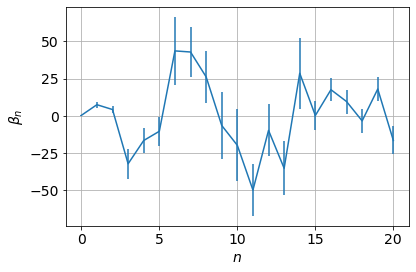

The variance is 570.689355922018
23.889105381366168
For the training data we get a MSE of
--------------------------------------------------------
MSE = |0.002100488609059984|, R2 = |0.9752080296699525|
--------------------------------------------------------

For the test data we get a MSE of
--------------------------------------------------------
MSE = |0.0020544886010784537|, R2 = |0.9753575988061614|
--------------------------------------------------------

(40000, 21)
(200, 200)
MSE_kfold:  0.0057924365066339195
bootTest:  0.002102698748632122


In [4]:
# Declaring polynomial degree
n = 5


# Making designfunction
X = create_X(x,y,n)



# Splitting in test/train
X_train, X_test, z_train, z_test = train_test_split(X, z.reshape(-1,1), test_size=0.2)

# Calculating the best coeffs for the OLS method
betaOLS = OLSmethod(X_train , z_train)


#finding the variance of beta and plotting the confidense interval
p = int((n+1)*(n+2)/2)


betaOLS_var = confidense(z_train,X_train)


plt.errorbar(range(p), betaOLS, yerr= betaOLS_var)

plt.xlabel(r"$n$")
plt.ylabel(r"$\beta_n$")
plt.grid()
plt.tight_layout()
plt.savefig("intervalofconfbeta.pdf")

plt.show()



print(f"The variance is {np.var(betaOLS)}")
print(np.std(betaOLS))



zpred = X_train@betaOLS
print("For the training data we get a MSE of")
printQ(z_train,zpred)


print("For the test data we get a MSE of")
ztilde = X_test@betaOLS
printQ(z_test,ztilde)



MSElist = []
R2list = []
for i in range(28):
    bootX,bootz = resample(X_train,z_train.reshape(-1,1))


    bootbetaOLS = OLSmethod(bootX,bootz)
    
    ypred = bootX @ bootbetaOLS
    MSElist.append(MSE(z_train,ypred))
    R2list.append(R2(bootz,ypred))
    

#X_scale = np.ones_like(X)
#scaler = StandardScaler()
#X_scale[1:,:] = scaler.fit_transform(X[1:,:])
#z_scaled = scaler.fit_transform(z.reshape(-1,1))




#X_strain, X_stest, z_strain, z_stest = train_test_split(X_scale, z_scaled.reshape(-1,1) , test_size = 0.2 )

#print(np.mean(MSElist))
#print(np.mean(R2list))

print('MSE_kfold: ',k_foldOLS(z.reshape(-1,1), 10,X))
boot_train_error, boot_test_error, variance,bias =BootstrapOLS(X_train,X_test,z_train,z_test,100)
print('bootTest: ', boot_test_error)


## For the scaled data 

### (This was not used but was interesting to compare the results)

In [5]:
scaler = StandardScaler()

X_scale = scaler.fit_transform(X)
z_scaled = scaler.fit_transform(z.reshape(-1,1))




X_strain, X_stest, z_strain, z_stest = train_test_split(X_scale, z_scaled.reshape(-1,1) , test_size = 0.2 )

betascaledOCS = np.linalg.pinv(X_strain.T@X_strain)@ X_strain.T @ z_strain
print(f"The variance of the scaled coefficients is {np.var(betascaledOCS)}\n")

zpreds = X_strain@betascaledOCS



print(f"Under we print the different values for MSE and R2")



print("For the scaled training data we get a MSE and R2 of:")
printQ(z_strain,zpreds)


print("For the scaled test data we get a MSE and R2 of: ")
ztilde = X_stest @ betascaledOCS

printQ(z_stest,ztilde)


The variance of the scaled coefficients is 339.12909124082165

Under we print the different values for MSE and R2
For the scaled training data we get a MSE and R2 of:
--------------------------------------------------------
MSE = |0.024792402151437604|, R2 = |0.9751633039431142|
--------------------------------------------------------

For the scaled test data we get a MSE and R2 of: 
--------------------------------------------------------
MSE = |0.024633925729804704|, R2 = |0.9755405206125036|
--------------------------------------------------------



## Task 2

The polynomial range is [0,17] 


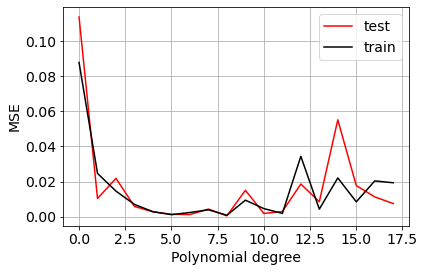

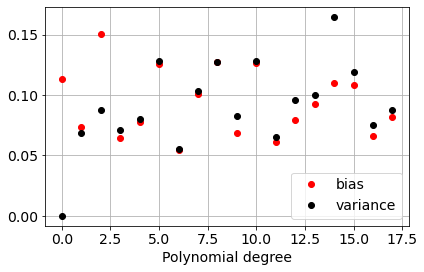

In [6]:
npoints = 17


# Make data.
x = np.sort(np.random.uniform(0, 1, npoints)) 
y = np.sort(np.random.uniform(0, 1, npoints)) 


x, y = np.meshgrid(x,y)


z = FrankeFunction(x, y) 
z = z + 0.01 * np.random.randn(npoints)


n = 17

plotMSEcomplexity(x,y,z,n)



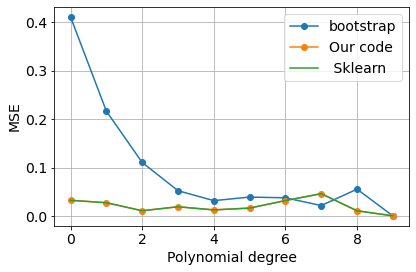

In [7]:
#This code section compares our K_fold and bootstrap against SKlearn

scaler = StandardScaler()


npoints = 40


# Make data.
x = np.sort(np.random.uniform(0, 1, npoints)) 
y = np.sort(np.random.uniform(0, 1, npoints)) 


xm, ym = np.meshgrid(x,y)


z = FrankeFunction(xm, ym).reshape(-1,1)

z = z + 0.01 * np.random.randn(npoints**2).reshape(-1,1)





# Setting the polynomial degree
n = 10
# Setting the k value for the folding
k = 10


# Creating arrays to store the MSE
estimated_mse_sklearn = np.zeros(n)
M_list = np.zeros(n)
boot_list = np.zeros(n)
kfoldc = KFold(n_splits = k)

for j in range(1,n):
    X = create_X(xm,ym,j)
    #X_scale = scaler.fit_transform(X)
    #z_scale = scaler.fit_transform(z.reshape(-1,1))
    M_list[j-1] = k_foldOLS(z,k,X)

    #Trying to impliment bootstrapOLS
    
    X_train, X_test, z_train, z_test = train_test_split(X,z.reshape(-1,1), test_size = 0.2)
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.fit_transform(X_test)
    z_train_scaled = scaler.fit_transform(z_train)
    z_test_scaled = scaler.fit_transform(z_test)
    
    
    test,train,bias,variance = BootstrapOLS(X_train_scaled,X_test_scaled,z_train_scaled,z_test_scaled,200)
    boot_list[j-1] = test
    

    # The Sklearn model
    ols1 = LinearRegression(fit_intercept = False)
    # cross_val_score return an array containing the estimated negative mse for every fold.
    # we have to the the mean of every array in order to get an estimate of the mse of the model
    estimated_mse_folds = cross_val_score(ols1, X, z, scoring='neg_mean_squared_error', cv=kfoldc)
    estimated_mse_sklearn[j-1] = np.mean(-estimated_mse_folds)



plt.plot(boot_list,"-o",label ="bootstrap")
plt.plot(M_list,"-o", label = "Our code")
plt.plot(estimated_mse_sklearn,"-", label = " Sklearn ")
plt.xlabel("Polynomial degree")
plt.ylabel("MSE")
plt.legend()
plt.grid()
#plt.title("Comparison of our k-fold and bootstrap model against Sklearn")
plt.tight_layout()
plt.savefig("Kfoldbootstpcomp.pdf")
plt.show()
    

    


## Task 4 and 5

In [8]:
# Declaring points
npoints = 10


# Make data.
x = np.sort(np.random.uniform(0, 1, npoints)) 
y = np.sort(np.random.uniform(0, 1, npoints)) 

# Meshgrid
xm, ym = np.meshgrid(x,y)


z = FrankeFunction(xm, ym).reshape(-1,1)

z = z + 0.01 * np.random.randn(npoints**2).reshape(-1,1)





# Setting the hyperparamaters
lam = np.logspace(-2,3)
lam_n = np.size(lam)

#Setting the max degree
degrees = 20
#for Ridge
Bootstrapp_train_errors = np.zeros((lam_n,degrees))
Bootstrapp_test_errors = np.zeros((lam_n,degrees))
bias_List =  np.zeros((lam_n,degrees))
variance_List = np.zeros((lam_n,degrees))

#for Lasso
Bootstrapp_train_errors_L = np.zeros((lam_n,degrees))
Bootstrapp_test_errors_L = np.zeros((lam_n,degrees))
bias_List_L =  np.zeros((lam_n,degrees))
variance_List_L = np.zeros((lam_n,degrees))


# Making the kfold arrays
k_foldMSE = np.zeros((lam_n,degrees))
k_foldMSE_L = np.zeros((lam_n,degrees))

# Declaring nfolds, use max since little data
k_folds = 10

i,j = 0,0
li = [0.2]

# Running a 2d for loop over the hyperparameter lambda and the degrees
for alpha in lam:
    for degree in range(degrees):
        # Create the designmatrix for n degree and splitting into test train
        X = create_X(xm,ym,degree)
        X_train, X_test, z_train, z_test = train_test_split(X, z.reshape(-1,1) , test_size = 0.2 )
        
        #Ridge
        bootstrap_train, bootstrap_test,bias,variance = BootstrapRidge(X_train,X_test,z_train,z_test,alpha,30)
        #Lasso
        bootstrap_train_L, bootstrap_test_L,bias_L,variance_L = BootstrapLasso(X_train,X_test,z_train,z_test,alpha,30)
        
        # adding the MSEs and other things of interest
        Bootstrapp_train_errors[i,j] =  bootstrap_train
        Bootstrapp_test_errors[i,j] = bootstrap_test
        bias_List[i,j] = bias
        variance_List[i,j] = variance
        
        #Lasso method on bootstrap samples
        Bootstrapp_train_errors_L[i,j] =  bootstrap_train_L
        Bootstrapp_test_errors_L[i,j] = bootstrap_test_L
        bias_List_L[i,j] = bias_L
        variance_List_L[i,j] = variance_L
        
        
        
        #k fold method for lasso and ridge, here we use scaled data
        X_scaled = scaler.fit_transform(X)
        z_scaled = scaler.fit_transform(z)
        k_foldMSE[i,j] = k_foldRigd(z_scaled, k_folds,X_scaled,alpha)
        k_foldMSE_L[i,j] = k_foldLasso(z_scaled, k_folds,X_scaled,alpha)
        
        j +=1
    i +=1
    j=0

14 7


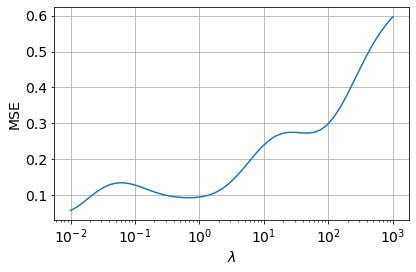

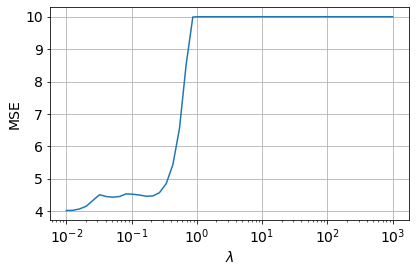

In [18]:

# Finding the polynomial degree with the least value for MSE for both ridge and lasso's kfold, this is plotted
bestpolyR = np.unravel_index(k_foldMSE.argmin(), k_foldMSE.shape)[1]
bestpolyL = np.unravel_index(k_foldMSE_L.argmin(), k_foldMSE_L.shape)[1]
print(bestpolyR,bestpolyL) # printing best degrees
plt.semilogx(lam,k_foldMSE[:,bestpolyR])
plt.grid()
plt.ylabel("MSE")
plt.xlabel("$\lambda$")
plt.tight_layout()

plt.savefig(f"Task4ridge_kfoldDeg{bestpolyR}.pdf")
plt.show()


plt.semilogx(lam,k_foldMSE_L[:,bestpolyL])
plt.grid()
plt.ylabel("MSE")
plt.xlabel("$\lambda$")
plt.tight_layout()

plt.savefig(f"Task5Lasso_kfoldDeg{bestpolyL}.pdf")

13


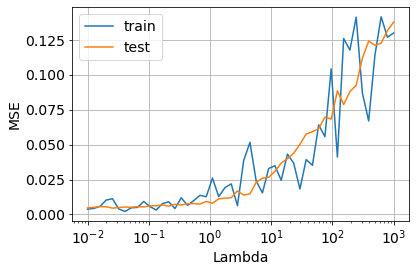

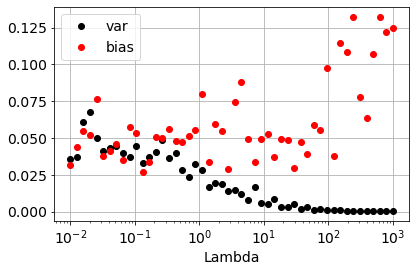

14


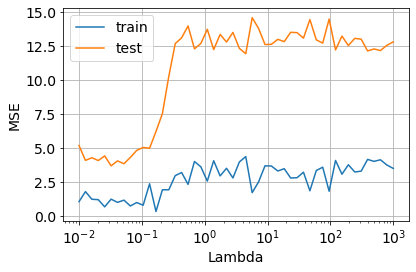

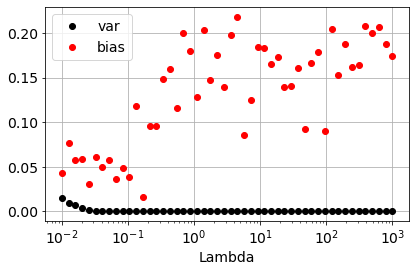

In [19]:
#Ridge

# Finding the polynomial degree with the least value for MSE for ridge this is plotted
ridgemin = np.unravel_index(Bootstrapp_train_errors.argmin(), Bootstrapp_train_errors.shape)[1]
print(ridgemin) # printing best degree
plt.semilogx(lam,Bootstrapp_train_errors[:,ridgemin],label='train')
plt.semilogx(lam,Bootstrapp_test_errors[:,ridgemin],label='test')
plt.legend()
plt.xlabel("Lambda")
plt.ylabel("MSE")
#plt.title(r"Figure of MSE for Ridge regression as a function of $\lambda$")
plt.tight_layout()
plt.grid()
plt.savefig(f"BestPolynom{ridgemin}RidgeBootstrap.pdf")
plt.show()

plt.semilogx(lam,variance_List[:,ridgemin],"ok",label='var')
plt.semilogx(lam,bias_List[:,ridgemin],"or",label='bias')
plt.legend()
plt.xlabel("Lambda")
plt.tight_layout()
plt.grid()
plt.savefig(f"BestPolynom{ridgemin}RidgeBootstrap_variance.pdf")
#plt.title(r"Figure of variance and bias for Ridge regression as a function of $\lambda$")
plt.show()

#Lasso
# Finding the polynomial degree with the least value for MSE for lasso this is plotted
lassomin = np.unravel_index(Bootstrapp_train_errors_L.argmin(), Bootstrapp_train_errors_L.shape)[1]
print(lassomin) # printing best degree
plt.semilogx(lam,Bootstrapp_train_errors_L[:,lassomin],label='train')
plt.semilogx(lam,Bootstrapp_test_errors_L[:,lassomin],label='test')
plt.legend()
plt.xlabel("Lambda")
#plt.title(r"Figure of MSE for Lasso regression as a function of $\lambda$")
plt.ylabel("MSE")

plt.tight_layout()
plt.grid()
plt.savefig(f"BestPolynomial{lassomin}LassoBootstrap.pdf")
plt.show()

plt.semilogx(lam,variance_List_L[:,lassomin],"ok",label='var')
plt.semilogx(lam,bias_List_L[:,lassomin],"or",label='bias')
plt.legend()

plt.xlabel("Lambda")
plt.grid()
plt.tight_layout()

plt.savefig(f"BestPolynomial{lassomin}Lasso_Variance.pdf")
#plt.title(r"Figure of variance and bias for Lasso regression as a function of $\lambda$")
plt.show()